## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [65]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [66]:
from sklearn import preprocessing

In [67]:
train, test = keras.datasets.cifar10.load_data()

In [121]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [122]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [70]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    exp_name_tag = "model 01"
    print(exp_name_tag)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [107]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [108]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="tmp00.h5", 
                             monitor="val_loss", 
                             save_best_only=True)
model_ckpt_bestonlyfalse = ModelCheckpoint(filepath="tmp01.h5", 
                             monitor="val_loss", 
                             save_best_only=False)
model_ckpt_weights_only = ModelCheckpoint(filepath="tmp02.h5", 
                             monitor="val_loss", 
                            save_weights_only=True)


In [109]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )



# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("tmp00.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)


model 01
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_78 (Batc (None, 128)         

50000/50000 [==============================] - 7s 146us/step - loss: 0.3651 - accuracy: 0.9193 - val_loss: 1.7443 - val_accuracy: 0.4849
Epoch 47/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3470 - accuracy: 0.9260 - val_loss: 1.7682 - val_accuracy: 0.4859
Epoch 48/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3301 - accuracy: 0.9316 - val_loss: 1.7828 - val_accuracy: 0.4847
Epoch 49/50
50000/50000 [==============================] - 7s 149us/step - loss: 0.3155 - accuracy: 0.9358 - val_loss: 1.8017 - val_accuracy: 0.4839
Epoch 50/50
10000/10000 [==============================] - 2s 164us/step


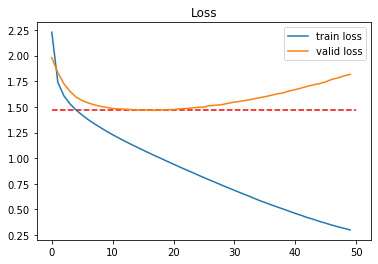

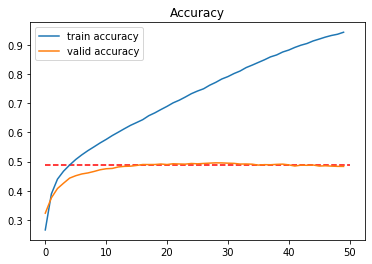

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

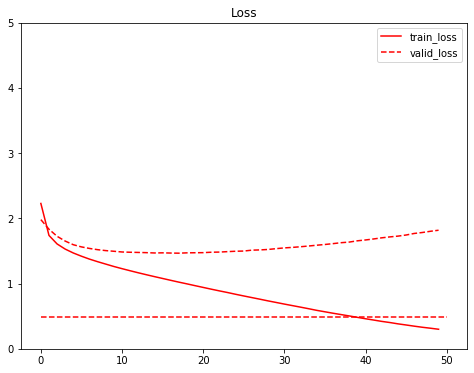

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_loss, label="train_loss",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, label="valid_loss",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

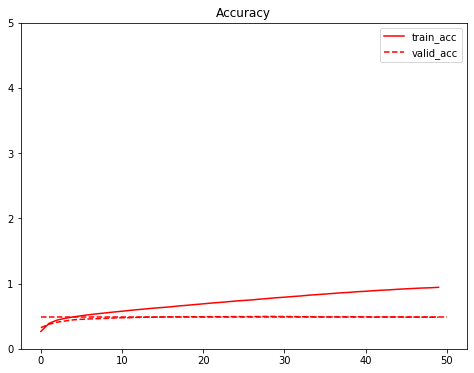

In [112]:
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_acc, label="train_acc",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_acc, label="valid_acc",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.ylim([0, 5])
plt.legend()
plt.show()

# best_only False

In [113]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_bestonlyfalse]
         )



# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("tmp01.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)



model 01
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_79 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_80 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_81 (Batc (None, 128)         

50000/50000 [==============================] - 7s 135us/step - loss: 0.3630 - accuracy: 0.9177 - val_loss: 1.7339 - val_accuracy: 0.4913
Epoch 47/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.3440 - accuracy: 0.9264 - val_loss: 1.7558 - val_accuracy: 0.4887
Epoch 48/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.3291 - accuracy: 0.9309 - val_loss: 1.7746 - val_accuracy: 0.4856
Epoch 49/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3124 - accuracy: 0.9375 - val_loss: 1.7875 - val_accuracy: 0.4881
Epoch 50/50
10000/10000 [==============================] - 2s 159us/step


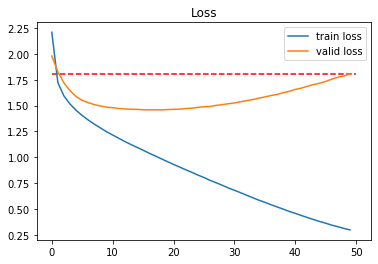

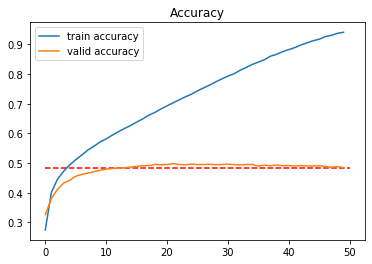

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

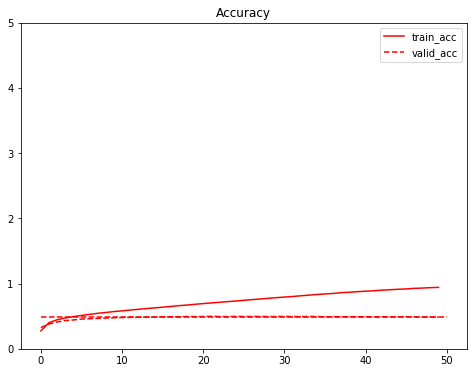

In [115]:
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_acc, label="train_acc",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_acc, label="valid_acc",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.ylim([0, 5])
plt.legend()
plt.show()

# weights only true

In [116]:
results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_weights_only]
         )



# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model.load_weights("tmp02.h5")# ＃＃＃＃＃load weights
y_predict=model.predict(x_test)




model 01
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_82 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_84 (Batc (None, 128)         

50000/50000 [==============================] - 12s 242us/step - loss: 0.3704 - accuracy: 0.9163 - val_loss: 1.7374 - val_accuracy: 0.4838
Epoch 47/50
50000/50000 [==============================] - 12s 242us/step - loss: 0.3520 - accuracy: 0.9241 - val_loss: 1.7518 - val_accuracy: 0.4845
Epoch 48/50
50000/50000 [==============================] - 12s 239us/step - loss: 0.3349 - accuracy: 0.9293 - val_loss: 1.7766 - val_accuracy: 0.4807
Epoch 49/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.3176 - accuracy: 0.9366 - val_loss: 1.7901 - val_accuracy: 0.4830
Epoch 50/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.3025 - accuracy: 0.9419 - val_loss: 1.8087 - val_accuracy: 0.4815


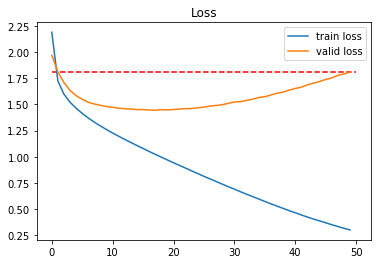

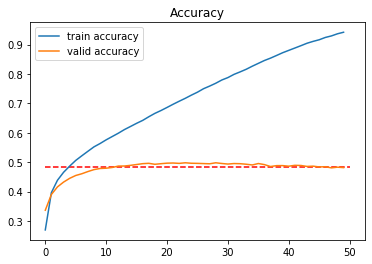

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

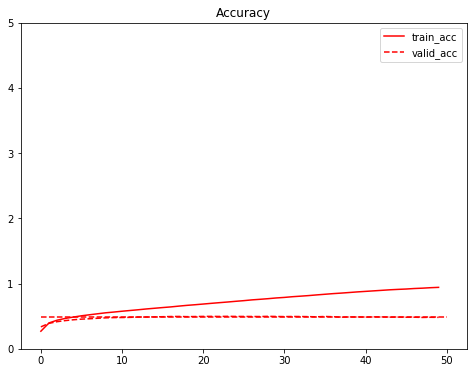

In [118]:
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_acc, label="train_acc",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_acc, label="valid_acc",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.ylim([0, 5])
plt.legend()
plt.show()

In [137]:
y_predict[9999][0]

0.0006356137

In [142]:
len(y_predict[0])
len(y_predict)
for i in range(10000):
    for j in range(10):
        if y_predict[i][j]<0.5:
            y_predict[i][j]=0
        else:
            y_predict[i][j]=1
y_predict

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [139]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [143]:
n=0
m=len(y_predict[0])*len(y_predict)
for i in range(10000):
    for j in range(10):
        if y_predict[i][j]==y_test[i][j]:
            n=n+1
        else:
            n=n
n/m

0.9062